In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
!pip install -q tensorflow-datasets tensorflow

In [36]:
#import more libraries
import re
import matplotlib.pyplot as plt
from keras.metrics import AUC
#import spicy
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Construct a tf.data.Dataset
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteCLAT27/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [5]:
#show the classes 
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


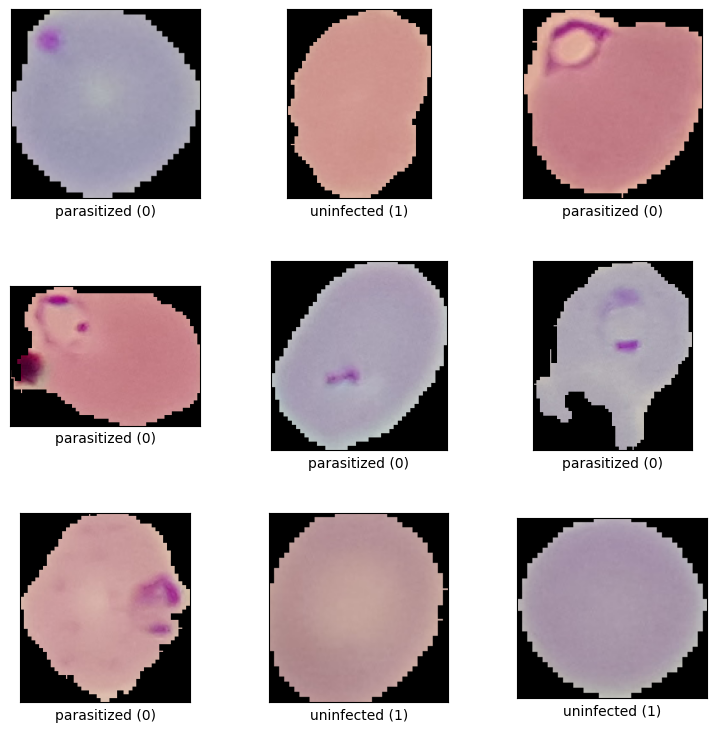

In [6]:
#visualizing the data
vis = tfds.visualization.show_examples(ds, info)

In [21]:
#Split the dataset into training, validation, and testing dataset.
BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

In [22]:
#confirm the ratios

NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


In [23]:
#check the image shape to confirm need for reshaping
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (103, 103, 3)
Label:  1


In [24]:
#reshaping the images to size (200,200)
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

In [25]:
#apply the reshape to all images which batching them.
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

In [37]:
#visualize reshaped images
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

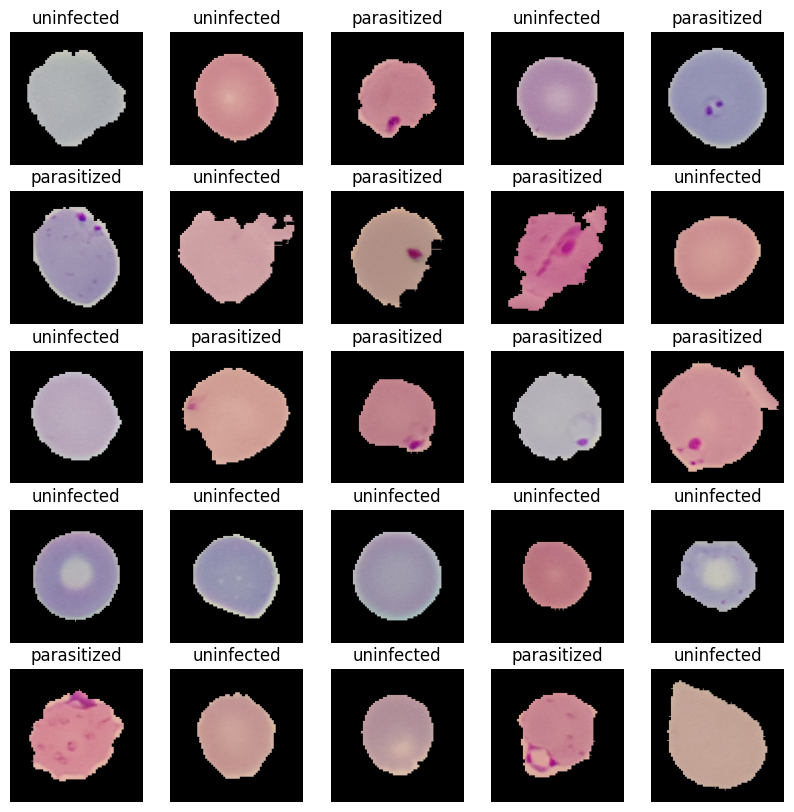

In [39]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [27]:
#building the model

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [28]:
#defining the model

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [29]:
#compiling the model

model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

In [30]:
#adding checkpoints

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model.keras",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [31]:
#training the model

history = model.fit(
    padded_train_ds, epochs=10,
    validation_data=padded_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/10
603/603 [==============================] - 816s 1s/step - loss: 0.6646 - auc: 0.6582 - val_loss: 7.2005 - val_auc: 0.5051 - lr: 0.0100
Epoch 2/10
603/603 [==============================] - 851s 1s/step - loss: 0.6401 - auc: 0.6852 - val_loss: 0.6562 - val_auc: 0.6923 - lr: 0.0089
Epoch 3/10
603/603 [==============================] - 846s 1s/step - loss: 0.6363 - auc: 0.6896 - val_loss: 0.9223 - val_auc: 0.3592 - lr: 0.0079
Epoch 4/10
603/603 [==============================] - 847s 1s/step - loss: 0.6357 - auc: 0.6906 - val_loss: 1.6886 - val_auc: 0.6672 - lr: 0.0071
Epoch 5/10
603/603 [==============================] - 850s 1s/step - loss: 0.6308 - auc: 0.6988 - val_loss: 0.7399 - val_auc: 0.4119 - lr: 0.0063
Epoch 6/10
603/603 [==============================] - 813s 1s/step - loss: 0.2561 - auc: 0.9556 - val_loss: 0.1957 - val_auc: 0.9862 - lr: 0.0056
Epoch 7/10
603/603 [==============================] - 856s 1s/step - loss: 0.1796 - auc: 0.9743 - val_loss: 0.1390 - val_auc

In [32]:
#Preprocessing the testing images

padded_test_ds = (
     test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

In [33]:
#evaluating the model

model.evaluate(padded_test_ds)

130/130 [==============================] - 46s 352ms/step - loss: 0.1324 - auc: 0.9879


[0.13239678740501404, 0.9878643751144409]

In [34]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 16)      0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 50, 50, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 25, 25, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 12, 12, 128)       27072     
                                                      